# MSE446 PROJECT - GROUP 7
### Liam McArdle, Connor Bechthold, Ritik Chanchlani


### Section 1 - Library Imports and General Preprocessing

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import shutil
import random

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

import tensorflow as tf

from keras import layers
from keras.models import Sequential
from keras.applications import ResNet50, MobileNetV2
from keras.applications.resnet50 import preprocess_input as resnet_preprocess
from keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, roc_auc_score, roc_curve 
import itertools

from ultralytics import YOLO

# Set our random seeds for reproducibile results
tf.random.set_seed(42)
np.random.seed(42)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2025-03-04 21:30:10.520518: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-04 21:30:10.520552: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-04 21:30:10.529594: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 21:30:10.768707: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 21:30:11.478182: W tensorflow/

Num GPUs Available:  1


2025-03-04 21:30:15.925212: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-04 21:30:15.929642: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-04 21:30:15.929670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [ ]:
# Split the Dataset between Train, Validation, and Test

# -------- CONFIGURATION --------
ROOT_DIR = "BreaKHis_v1/dataset" 
OUT_DIR  = "Split_80_10_10" 

# Create these subfolders:
# Split_80_10_10/
#    train/Benign/
#    train/Malignant/
#    val/Benign/
#    val/Malignant/
#    test/Benign/
#    test/Malignant/

# Reproducible shuffle
random.seed(42)

# 80/10/10 => 10% test, 10% val, 80% train
TEST_FRAC = 0.1
# We do test first. Then among the remainder (0.9), we want val = (0.1 / 0.9) ~ 0.1111
VAL_FRAC_OF_REMAINDER = 0.1 / 0.9  # ~0.1111


# -------- HELPER FUNCTIONS --------

def parse_filename(fname):
    """
    Example: SOB_B_A-14-22549AB-100-015.png
    Return: (tumor_class, magnification), e.g. ('B', '100')
    """
    core = fname.replace(".png","")
    parts = core.split("_")  # e.g. ['SOB', 'B', 'A-14-22549AB-100-015']
    if len(parts) < 3:
        return None, None
    tumor_class = parts[1]  # 'B' or 'M'
    
    # The last chunk might look like "A-14-22549AB-100-015"
    sub = parts[2].split("-")
    # e.g. ['A','14','22549AB','100','015']
    if len(sub) < 5:
        return None, None
    magnification = sub[-2]  # e.g. '100'
    return tumor_class, magnification

def ensure_exists(path):
    if not os.path.exists(path):
        os.makedirs(path)

# We'll hold everything in a dict keyed by (tumor_class, mag)
images_by_group = {}

def add_to_group(path, c, mag):
    key = (c, mag)
    if key not in images_by_group:
        images_by_group[key] = []
    images_by_group[key].append(path)

# -------- GATHER BENIGN FILES --------
benign_root = os.path.join(ROOT_DIR, "Benign")
for dirpath, dirs, files in os.walk(benign_root):
    for f in files:
        if f.lower().endswith(".png"):
            full_path = os.path.join(dirpath, f)
            tc, mag = parse_filename(f)
            if tc == 'B' and mag:
                add_to_group(full_path, tc, mag)

# -------- GATHER MALIGNANT FILES --------
mal_root = os.path.join(ROOT_DIR, "Malignant")
for dirpath, dirs, files in os.walk(mal_root):
    for f in files:
        if f.lower().endswith(".png"):
            full_path = os.path.join(dirpath, f)
            tc, mag = parse_filename(f)
            if tc == 'M' and mag:
                add_to_group(full_path, tc, mag)

# Prepare final sets:
train_paths = []
val_paths   = []
test_paths  = []

# -------- SPLIT 80/10/10 PER GROUP --------
for (tc, mag), fpaths in images_by_group.items():
    random.shuffle(fpaths)
    n_total = len(fpaths)
    n_test = int(TEST_FRAC * n_total)  # ~10%
    test_subset = fpaths[:n_test]
    
    trainval_subset = fpaths[n_test:]       # ~90% remain
    n_val = int(VAL_FRAC_OF_REMAINDER * len(trainval_subset))  # ~10% of the total
    val_subset = trainval_subset[:n_val]
    train_subset = trainval_subset[n_val:]
    
    test_paths.extend(test_subset)
    val_paths.extend(val_subset)
    train_paths.extend(train_subset)

# We'll create these folders:
train_benign_dir = os.path.join(OUT_DIR, "train", "Benign")
train_malign_dir = os.path.join(OUT_DIR, "train", "Malignant")
val_benign_dir   = os.path.join(OUT_DIR, "val",   "Benign")
val_malign_dir   = os.path.join(OUT_DIR, "val",   "Malignant")
test_benign_dir  = os.path.join(OUT_DIR, "test",  "Benign")
test_malign_dir  = os.path.join(OUT_DIR, "test",  "Malignant")

for d in [train_benign_dir, train_malign_dir,
          val_benign_dir,   val_malign_dir,
          test_benign_dir,  test_malign_dir]:
    ensure_exists(d)

def copy_to_split(paths, split_benign_dir, split_malign_dir):
    for p in paths:
        fname = os.path.basename(p)
        c, _ = parse_filename(fname)
        if c == 'B':
            shutil.copy2(p, os.path.join(split_benign_dir, fname))
        else:
            shutil.copy2(p, os.path.join(split_malign_dir, fname))

# Copy them
copy_to_split(train_paths, train_benign_dir, train_malign_dir)
copy_to_split(val_paths,   val_benign_dir,   val_malign_dir)
copy_to_split(test_paths,  test_benign_dir,  test_malign_dir)

print("Done! Final splits:")
print(f"Train: {len(train_paths)} images")
print(f"Val:   {len(val_paths)} images")
print(f"Test:  {len(test_paths)} images")


Done! Final splits:
Train: 6333 images
Val:   788 images
Test:  788 images


### Section 2 - Loading, Preparing, and Visualizing Data 

In [9]:
DATA_DIR = "BreaKHis_v1/"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")
TEST_DIR  = os.path.join(DATA_DIR, "test")

# Hyperparameters
IMG_SIZE = (224, 224)   
BATCH_SIZE = 32
EPOCHS = 100

# Load training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',       # it infers class labels from subfolder names: 'Benign', 'Malignant'
    label_mode='binary',     # 0/1 labels
    image_size=IMG_SIZE,
    interpolation='lanczos3',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    interpolation='lanczos3',
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Load test set
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred',
    label_mode='binary',
    image_size=IMG_SIZE,
    interpolation='lanczos3',
    batch_size=BATCH_SIZE,
    shuffle=False  # don't shuffle test data
)

# Augment our dataset to reduce the chances of overfitting
def random_augment(image):
    """Apply random data augmentations: flips, brightness, etc."""
    image = tf.image.random_flip_left_right(image, seed=42)
    image = tf.image.random_flip_up_down(image, seed=42)
    image = tf.image.random_brightness(image, max_delta=0.2, seed=42)
    return image

def augment_ds(ds):
    """Map 'random_augment' only to the images in (image, label)."""
    return ds.map(
        lambda x, y: (random_augment(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

# Speed up training a little
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(
    lambda x,y: (tf.cast(x, tf.float32), y),  # ensure float before augmentation
    num_parallel_calls=AUTOTUNE
)
train_ds = augment_ds(train_ds)  # apply random_augment

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Preprocessing for ResNet50
def map_resnet(ds):
    return ds.map(lambda x, y: (resnet_preprocess(tf.cast(x, tf.float32)), y),
                  num_parallel_calls=tf.data.AUTOTUNE)

# Preprocessing for MobileNetV2
def map_mobilenet(ds):
    return ds.map(lambda x, y: (mobilenet_preprocess(tf.cast(x, tf.float32)), y),
                  num_parallel_calls=tf.data.AUTOTUNE)



Found 6333 files belonging to 2 classes.
Found 788 files belonging to 2 classes.
Found 788 files belonging to 2 classes.


2025-03-04 18:31:17.322312: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


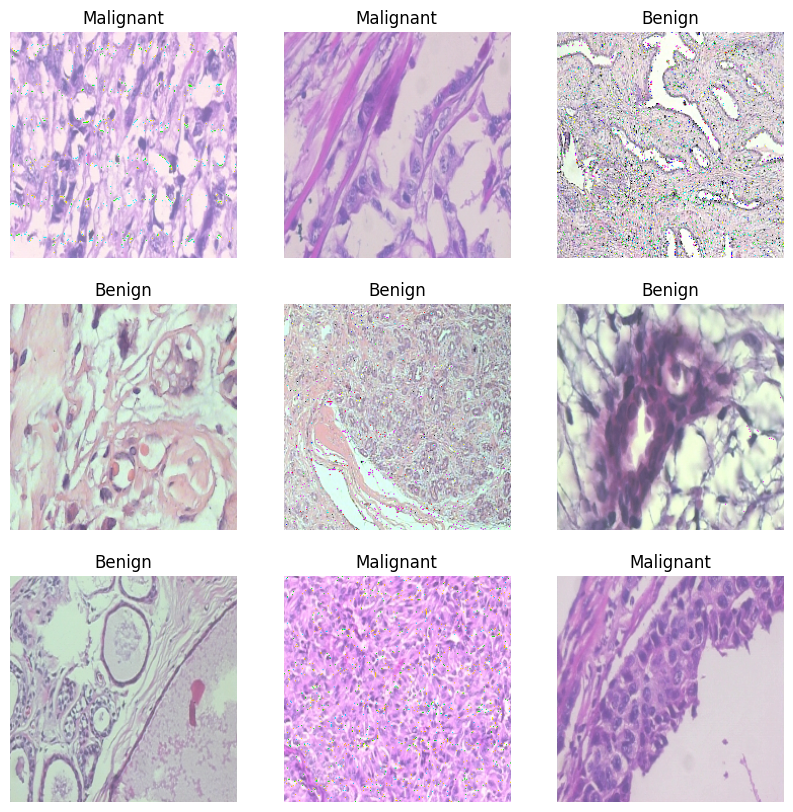

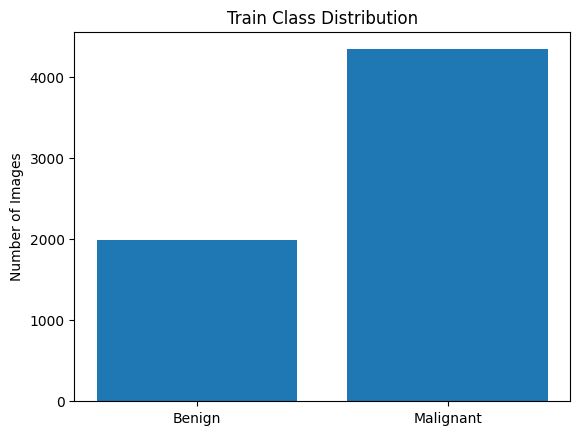

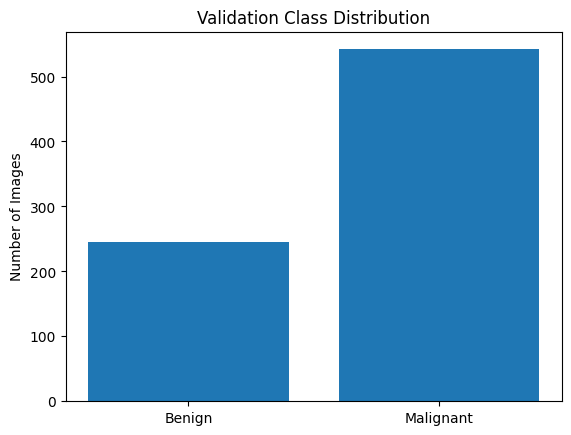

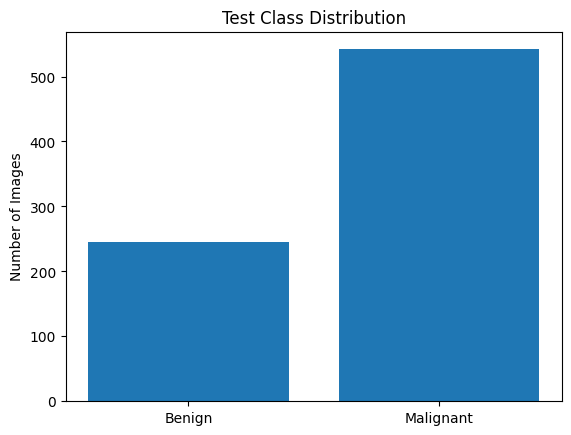

In [3]:
# Some Data Visualization

sample_batch = next(iter(train_ds))
images, labels = sample_batch

plt.figure(figsize=(10, 10))
for i in range(min(9, len(images))):  # show up to 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_str = "Benign" if labels[i].numpy() == 0 else "Malignant"
    plt.title(label_str)
    plt.axis("off")
plt.show()

### Define a helper to count class distribution ###
def count_class_distribution(dataset):
    benign_count = 0
    malignant_count = 0
    # unbatch so we can iterate over individual samples
    for img, lbl in dataset.unbatch():
        if lbl == 0:
            benign_count += 1
        else:
            malignant_count += 1
    return benign_count, malignant_count

### Plot bar charts for train, val, test ###

def plot_distribution(title, benign_count, malignant_count):
    plt.figure()
    plt.bar(["Benign", "Malignant"], [benign_count, malignant_count])
    plt.title(title)
    plt.ylabel("Number of Images")
    plt.show()

# -- Train distribution --
train_benign, train_malign = count_class_distribution(train_ds)
plot_distribution("Train Class Distribution", train_benign, train_malign)

# -- Val distribution --
val_benign, val_malign = count_class_distribution(val_ds)
plot_distribution("Validation Class Distribution", val_benign, val_malign)

# -- Test distribution --
test_benign, test_malign = count_class_distribution(test_ds)
plot_distribution("Test Class Distribution", test_benign, test_malign)

In [4]:
# Some useful helper functions for analyzing the results

def plot_confusion_matrix(labels, preds, class_names, normalize=False):
    cm = confusion_matrix(labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(include_values=True, cmap="Blues", xticks_rotation='horizontal')
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_curve(labels, probs, class_names):
    fpr, tpr, thresholds = roc_curve(labels, probs)
    roc_auc = roc_auc_score(labels, probs)
    
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

### Section 3 - Model Definitions and Setup

Custom CNN

In [5]:
def create_custom_cnn(input_shape=(224, 224, 3)):
    model = Sequential([
        layers.Input(shape=input_shape),
        
        # Convolutional block I
        layers.Rescaling(1./255),
        layers.BatchNormalization(),
        layers.Conv2D(32, 3, activation="relu"),
        layers.MaxPooling2D(),
        
        # Convolutional block II
        layers.Conv2D(64, 3, activation="relu"),
        layers.MaxPooling2D(),
        
        # Convolutional block III
        layers.Conv2D(128, 3, activation="relu"),
        layers.MaxPooling2D(),
        
        # Fully connected layers
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid")
    ], name="Custom_CNN")
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

custom_cnn = create_custom_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
custom_cnn.summary()

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True  
)

checkpoint_path = "custom_cnn_weights.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

custom_cnn_callbacks_list = [early_stop, model_checkpoint, reduce_lr]


Model: "Custom_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 batch_normalization (Batch  (None, 224, 224, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0

ResNet50 with Detection Head

In [ ]:
def create_resnet50_model(input_shape=(224, 224, 3)):
    base_model = ResNet50(
        weights='imagenet', 
        include_top=False, 
        input_shape=input_shape
    )
    # Freeze the base so it doesn’t train initial layers (optional)
    base_model.trainable = False
    
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    
    model = tf.keras.Model(name='ResNet50_Model', inputs=base_model.input, outputs=output)
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

resnet50_model = create_resnet50_model()
resnet50_model.summary()

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, # Give more patience, as it is a larger model it might take longer to converge.
    restore_best_weights=True  
)

checkpoint_path = "resnet_model_weights.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

restnet_callbacks_list = [early_stop, model_checkpoint, reduce_lr]

Model: "ResNet50_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                 

MobileNetV2 with Detection Head

In [ ]:
def create_mobilenetv2_model(input_shape=(224, 224, 3)):
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    # Freeze base layers
    base_model.trainable = False
    
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    output = layers.Dense(1, activation="sigmoid")(x)
    
    model = tf.keras.Model(name='MobileNetV2_Model', inputs=base_model.input, outputs=output)
    
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

mobilenetv2_model = create_mobilenetv2_model()
mobilenetv2_model.summary()

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True  
)

checkpoint_path = "mobilenet_model_weights.h5"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

mobilenet_callbacks_list = [early_stop, model_checkpoint, reduce_lr]


Model: "MobileNetV2_Model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][

### Section 4 - Training

In [9]:
print("=== Training Custom CNN ===")
history_custom = custom_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=custom_cnn_callbacks_list
)

=== Training Custom CNN ===
Epoch 1/100


2025-03-04 18:34:48.926417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-03-04 18:34:49.986436: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3833279f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-04 18:34:49.986460: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-03-04 18:34:49.991600: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-04 18:34:50.043488: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/198 [==============================] - ETA: 0s - loss: 0.4603 - accuracy: 0.8080
Epoch 1: val_loss improved from inf to 0.59266, saving model to custom_cnn_weights.h5
198/198 [==============================] - 12s 45ms/step - loss: 0.4603 - accuracy: 0.8080 - val_loss: 0.5927 - val_accuracy: 0.6878 - lr: 0.0010
Epoch 2/100
196/198 [============================>.] - ETA: 0s - loss: 0.3908 - accuracy: 0.8382
Epoch 2: val_loss improved from 0.59266 to 0.43589, saving model to custom_cnn_weights.h5
198/198 [==============================] - 4s 22ms/step - loss: 0.3907 - accuracy: 0.8380 - val_loss: 0.4359 - val_accuracy: 0.8122 - lr: 0.0010
Epoch 3/100
196/198 [============================>.] - ETA: 0s - loss: 0.3707 - accuracy: 0.8500
Epoch 3: val_loss improved from 0.43589 to 0.36592, saving model to custom_cnn_weights.h5
198/198 [==============================] - 4s 22ms/step - loss: 0.3707 - accuracy: 0.8498 - val_loss: 0.3659 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 4/100
196/198

In [10]:
print("=== Training ResNet50 ===")

train_ds_resnet = map_resnet(train_ds)
val_ds_resnet = map_resnet(val_ds)
test_ds_resnet = map_resnet(test_ds)

history_resnet = resnet50_model.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=EPOCHS,
    callbacks=restnet_callbacks_list
)

=== Training ResNet50 ===
Epoch 1/100
198/198 [==============================] - ETA: 0s - loss: 0.4800 - accuracy: 0.8168
Epoch 1: val_loss improved from inf to 2.40190, saving model to resnet_model_weights.h5
198/198 [==============================] - 40s 128ms/step - loss: 0.4800 - accuracy: 0.8168 - val_loss: 2.4019 - val_accuracy: 0.8160 - lr: 0.0010
Epoch 2/100
198/198 [==============================] - ETA: 0s - loss: 0.3661 - accuracy: 0.8554
Epoch 2: val_loss improved from 2.40190 to 0.35698, saving model to resnet_model_weights.h5
198/198 [==============================] - 22s 112ms/step - loss: 0.3661 - accuracy: 0.8554 - val_loss: 0.3570 - val_accuracy: 0.8490 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - ETA: 0s - loss: 0.3030 - accuracy: 0.8716
Epoch 3: val_loss did not improve from 0.35698
198/198 [==============================] - 19s 96ms/step - loss: 0.3030 - accuracy: 0.8716 - val_loss: 0.9098 - val_accuracy: 0.6599 - lr: 0.0010
Epoch 4/100
198/

In [11]:
print("=== Training MobileNetV2 ===")

train_ds_mobilenet = map_mobilenet(train_ds)
val_ds_mobilenet = map_mobilenet(val_ds)
test_ds_mobilenet = map_mobilenet(test_ds)

history_mobilenet = mobilenetv2_model.fit(
    train_ds_mobilenet,
    validation_data=val_ds_mobilenet,
    epochs=EPOCHS,
    callbacks=mobilenet_callbacks_list
)

=== Training MobileNetV2 ===
Epoch 1/100
198/198 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.8476
Epoch 1: val_loss improved from inf to 2.86098, saving model to mobilenet_model_weights.h5
198/198 [==============================] - 26s 60ms/step - loss: 0.3631 - accuracy: 0.8476 - val_loss: 2.8610 - val_accuracy: 0.5964 - lr: 0.0010
Epoch 2/100
197/198 [============================>.] - ETA: 0s - loss: 0.2185 - accuracy: 0.9210
Epoch 2: val_loss improved from 2.86098 to 2.10295, saving model to mobilenet_model_weights.h5
198/198 [==============================] - 9s 45ms/step - loss: 0.2189 - accuracy: 0.9209 - val_loss: 2.1029 - val_accuracy: 0.5381 - lr: 0.0010
Epoch 3/100
198/198 [==============================] - ETA: 0s - loss: 0.1629 - accuracy: 0.9398
Epoch 3: val_loss did not improve from 2.10295
198/198 [==============================] - 11s 57ms/step - loss: 0.1629 - accuracy: 0.9398 - val_loss: 6.1525 - val_accuracy: 0.3096 - lr: 0.0010
Epoch 4/10

### Section 5 - Evaluating Test Set

In [12]:
def evaluate_model(model, dataset, name="Model"):
    # 1) Collect all predictions and labels
    all_labels = []
    all_probs = []
    for images, labels in dataset:
        probs = model.predict(images).ravel()
        all_probs.extend(probs)
        all_labels.extend(labels.numpy().astype(int))

    all_labels = np.array(all_labels)
    all_probs  = np.array(all_probs)
    all_preds  = (all_probs >= 0.5).astype(int)

    # 2) Confusion Matrix
    print(f"\n=== {name} Confusion Matrix ===")
    plot_confusion_matrix(all_labels, all_preds, class_names=["Benign", "Malignant"])

    # 3) Classification Report
    print(f"=== {name} Classification Report ===")
    print(classification_report(all_labels, all_preds, target_names=["Benign (0)", "Malignant (1)"]))

    # 4) ROC / AUC
    roc_score = roc_auc_score(all_labels, all_probs)
    print(f"=== {name} ROC AUC: {roc_score:.4f} ===")
    plot_roc_curve(all_labels, all_probs, class_names=["Benign", "Malignant"])

=== Evaluating Custom CNN on Test Set ===
25/25 [==============================] - 4s 140ms/step - loss: 0.1357 - accuracy: 0.9365
Test Accuracy (Custom CNN): 93.65%
1/1 [==============================] - 0s 12ms/step

=== Custom_CNN Confusion Matrix ===


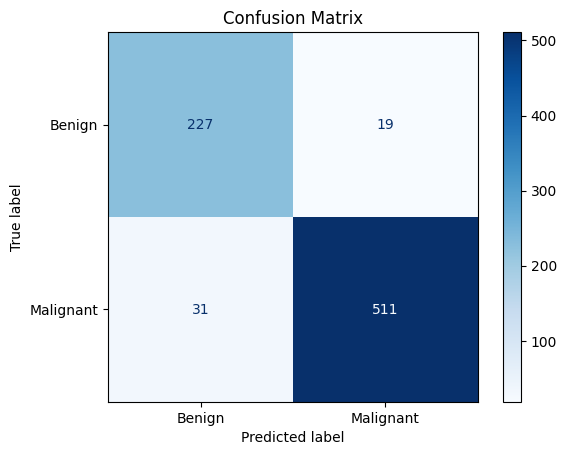

=== Custom_CNN Classification Report ===
               precision    recall  f1-score   support

   Benign (0)       0.88      0.92      0.90       246
Malignant (1)       0.96      0.94      0.95       542

     accuracy                           0.94       788
    macro avg       0.92      0.93      0.93       788
 weighted avg       0.94      0.94      0.94       788

=== Custom_CNN ROC AUC: 0.9875 ===


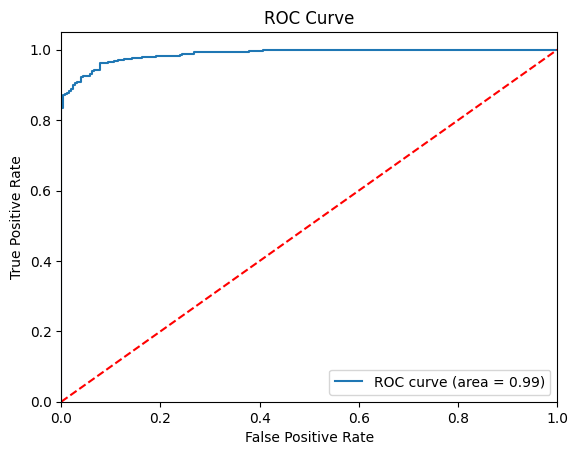

In [19]:
print("=== Evaluating Custom CNN on Test Set ===")
test_loss_c, test_acc_c = custom_cnn.evaluate(test_ds)
print(f"Test Accuracy (Custom CNN): {test_acc_c*100:.2f}%")
evaluate_model(custom_cnn, test_ds, name="Custom_CNN")

=== Evaluating ResNet50 on Test Set ===
25/25 [==============================] - 1s 33ms/step - loss: 0.1405 - accuracy: 0.9467
Test Accuracy (ResNet50): 94.67%
1/1 [==============================] - 0s 15ms/step

=== ResNet50_Model Confusion Matrix ===


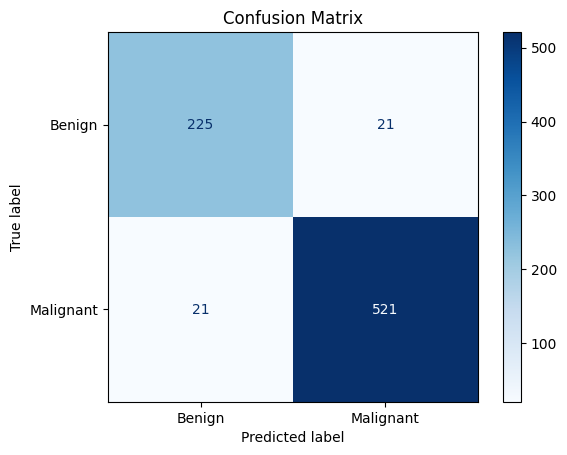

=== ResNet50_Model Classification Report ===
               precision    recall  f1-score   support

   Benign (0)       0.91      0.91      0.91       246
Malignant (1)       0.96      0.96      0.96       542

     accuracy                           0.95       788
    macro avg       0.94      0.94      0.94       788
 weighted avg       0.95      0.95      0.95       788

=== ResNet50_Model ROC AUC: 0.9868 ===


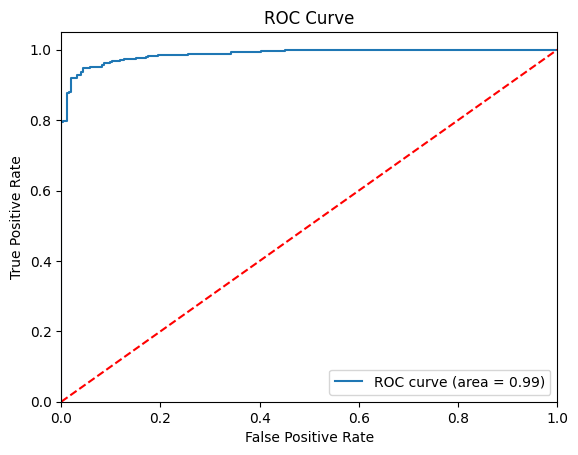

In [20]:
print("=== Evaluating ResNet50 on Test Set ===")
test_loss_r, test_acc_r = resnet50_model.evaluate(test_ds_resnet)
print(f"Test Accuracy (ResNet50): {test_acc_r*100:.2f}%")
evaluate_model(resnet50_model, test_ds_resnet, name="ResNet50_Model")

=== Evaluating MobileNetV2 on Test Set ===
25/25 [==============================] - 0s 16ms/step - loss: 0.1707 - accuracy: 0.9708
Test Accuracy (MobileNetV2): 97.08%
1/1 [==============================] - 0s 15ms/step

=== MobileNetV2_Model Confusion Matrix ===


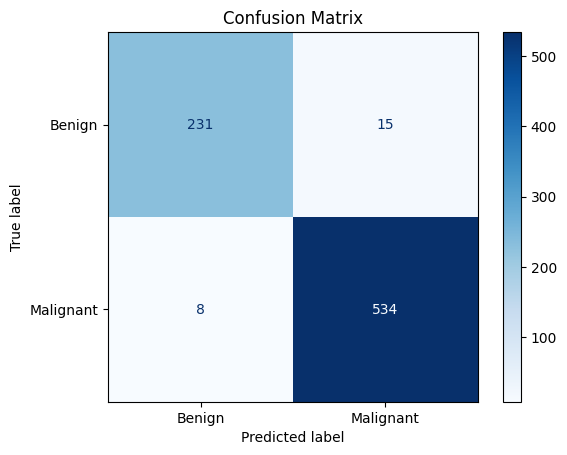

=== MobileNetV2_Model Classification Report ===
               precision    recall  f1-score   support

   Benign (0)       0.97      0.94      0.95       246
Malignant (1)       0.97      0.99      0.98       542

     accuracy                           0.97       788
    macro avg       0.97      0.96      0.97       788
 weighted avg       0.97      0.97      0.97       788

=== MobileNetV2_Model ROC AUC: 0.9937 ===


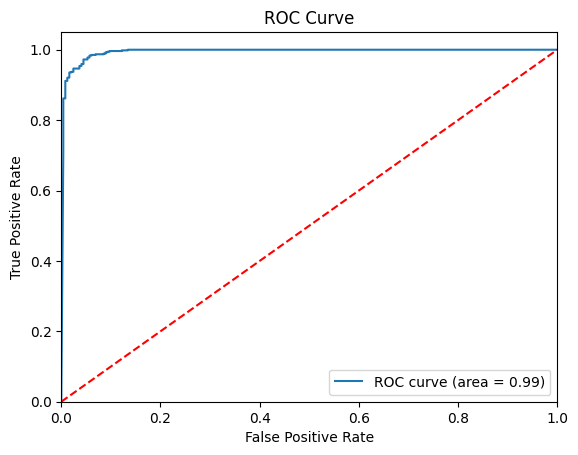

In [21]:
print("=== Evaluating MobileNetV2 on Test Set ===")
test_loss_m, test_acc_m = mobilenetv2_model.evaluate(test_ds_mobilenet)
print(f"Test Accuracy (MobileNetV2): {test_acc_m*100:.2f}%")
evaluate_model(mobilenetv2_model, test_ds_mobilenet, name="MobileNetV2_Model")

### Section 6 - Running on YOLO

In [ ]:
model = YOLO(model="/home/lmcardle/developer/MSE446/YOLO/yolov8m-cls.pt", task='classify')

In [37]:
results = model.train(
    data="/home/lmcardle/developer/MSE446/BreaKHis_v1/", 
    epochs=50,             
    imgsz=224,             
    batch=32,              
    device='cuda',
    patience=10,
    project='YOLO',
    name='breast-cancer-tumour-classification'            
)

Ultralytics 8.3.83 🚀 Python-3.9.21 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10239MiB)
engine/trainer: task=classify, mode=train, model=/home/lmcardle/developer/MSE446/YOLO/yolov8m-cls.pt, data=/home/lmcardle/developer/MSE446/BreaKHis_v1/, epochs=50, time=None, patience=10, batch=32, imgsz=224, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=YOLO, name=breast-cancer-tumour-classification, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fram

train: Scanning /home/lmcardle/developer/MSE446/BreaKHis_v1/train... 6333 images, 0 corrupt: 100%|██████████| 6333/6333 [00:00<?, ?it/s]
val: Scanning /home/lmcardle/developer/MSE446/BreaKHis_v1/val... 788 images, 0 corrupt: 100%|██████████| 788/788 [00:00<?, ?it/s]


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 38 weight(decay=0.0), 39 weight(decay=0.0005), 39 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to YOLO/breast-cancer-tumour-classification
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 32.98it/s]

                   all      0.915          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 47.35it/s]

                   all      0.905          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 14.03it/s]

                   all      0.849          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:01<00:00, 10.72it/s]

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:01<00:00, 11.96it/s]

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:01<00:00, 10.35it/s]

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 16.51it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 40.28it/s]

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 48.61it/s]

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50      1.67G     0.2053         29        224: 100%|██████████| 198/198 [00:13<00:00, 14.90it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 51.81it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50      1.64G     0.1953         29        224: 100%|██████████| 198/198 [00:11<00:00, 16.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 51.88it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50      1.68G     0.1939         29        224: 100%|██████████| 198/198 [00:15<00:00, 12.50it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 36.94it/s]

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      1.68G     0.1842         29        224: 100%|██████████| 198/198 [00:07<00:00, 25.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 51.78it/s]

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50      1.67G     0.1658         29        224: 100%|██████████| 198/198 [00:10<00:00, 18.93it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 49.97it/s]

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50      1.68G     0.1707         29        224: 100%|██████████| 198/198 [00:07<00:00, 26.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 49.00it/s]

                   all      0.963          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      1.68G     0.1596         29        224: 100%|██████████| 198/198 [00:07<00:00, 26.03it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 49.00it/s]

                   all      0.961          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      1.68G     0.1544         29        224: 100%|██████████| 198/198 [00:07<00:00, 26.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 48.47it/s]

                   all      0.962          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50      1.67G     0.1627         29        224: 100%|██████████| 198/198 [00:10<00:00, 18.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 49.25it/s]

                   all      0.958          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50      1.67G     0.1309         29        224: 100%|██████████| 198/198 [00:07<00:00, 25.80it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 49.34it/s]

                   all      0.968          1



      Epoch    GPU_mem       loss  Instances       Size


      20/50      1.68G     0.1303         29        224: 100%|██████████| 198/198 [00:07<00:00, 26.20it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 52.54it/s]

                   all       0.97          1



      Epoch    GPU_mem       loss  Instances       Size


      21/50      1.68G      0.135         29        224: 100%|██████████| 198/198 [00:10<00:00, 18.89it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 45.43it/s]

                   all      0.976          1



      Epoch    GPU_mem       loss  Instances       Size


      22/50      1.68G     0.1296         29        224: 100%|██████████| 198/198 [00:07<00:00, 25.38it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 46.75it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


      23/50      1.68G     0.1381         29        224: 100%|██████████| 198/198 [00:07<00:00, 25.02it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 46.99it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


      24/50      1.64G     0.1143         29        224: 100%|██████████| 198/198 [00:07<00:00, 25.26it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 46.51it/s]

                   all      0.972          1



      Epoch    GPU_mem       loss  Instances       Size


      25/50      1.68G     0.1229         29        224: 100%|██████████| 198/198 [00:10<00:00, 18.59it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 53.57it/s]

                   all      0.973          1



      Epoch    GPU_mem       loss  Instances       Size


      26/50      1.67G     0.1222         29        224: 100%|██████████| 198/198 [00:07<00:00, 26.37it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 49.96it/s]

                   all      0.978          1



      Epoch    GPU_mem       loss  Instances       Size


      27/50      1.68G    0.09578         29        224: 100%|██████████| 198/198 [00:07<00:00, 26.22it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 50.07it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      28/50      1.67G     0.1044         29        224: 100%|██████████| 198/198 [00:07<00:00, 26.25it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 50.84it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


      29/50      1.68G     0.1058         29        224: 100%|██████████| 198/198 [00:10<00:00, 18.33it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 46.83it/s]

                   all      0.975          1



      Epoch    GPU_mem       loss  Instances       Size


      30/50      1.68G     0.1064         29        224: 100%|██████████| 198/198 [00:07<00:00, 25.32it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 47.51it/s]

                   all      0.981          1



      Epoch    GPU_mem       loss  Instances       Size


      31/50      1.68G     0.1012         29        224: 100%|██████████| 198/198 [00:07<00:00, 25.34it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 51.53it/s]

                   all      0.981          1



      Epoch    GPU_mem       loss  Instances       Size


      32/50      1.68G    0.09659         29        224: 100%|██████████| 198/198 [00:07<00:00, 26.04it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 38.72it/s]

                   all      0.976          1



      Epoch    GPU_mem       loss  Instances       Size


      33/50      1.68G    0.08915         29        224: 100%|██████████| 198/198 [00:10<00:00, 18.61it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 14.30it/s]

                   all      0.986          1



      Epoch    GPU_mem       loss  Instances       Size


      34/50      1.67G    0.08614         29        224: 100%|██████████| 198/198 [00:07<00:00, 25.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 47.05it/s]

                   all      0.977          1



      Epoch    GPU_mem       loss  Instances       Size


      35/50      1.68G      0.081         29        224: 100%|██████████| 198/198 [00:07<00:00, 26.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 46.14it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


      36/50      1.68G    0.07651         29        224: 100%|██████████| 198/198 [00:12<00:00, 15.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 13.84it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


      37/50      1.68G    0.06488         29        224: 100%|██████████| 198/198 [00:09<00:00, 21.60it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:01<00:00, 12.78it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


      38/50      1.64G    0.06616         29        224: 100%|██████████| 198/198 [00:09<00:00, 21.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:01<00:00, 12.71it/s]

                   all      0.976          1



      Epoch    GPU_mem       loss  Instances       Size


      39/50      1.67G    0.05652         29        224: 100%|██████████| 198/198 [00:08<00:00, 22.62it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:03<00:00,  3.25it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


      40/50      1.69G    0.05794         29        224: 100%|██████████| 198/198 [00:07<00:00, 25.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 51.55it/s]

                   all      0.985          1



      Epoch    GPU_mem       loss  Instances       Size


      41/50      1.68G    0.05193         29        224: 100%|██████████| 198/198 [00:08<00:00, 23.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 49.26it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


      42/50      1.64G     0.0528         29        224: 100%|██████████| 198/198 [00:07<00:00, 25.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 49.46it/s]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


      43/50      1.67G    0.05788         29        224: 100%|██████████| 198/198 [00:10<00:00, 18.85it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 46.90it/s]

                   all      0.987          1



      Epoch    GPU_mem       loss  Instances       Size


      44/50      1.68G    0.04685         29        224: 100%|██████████| 198/198 [00:07<00:00, 26.10it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 46.58it/s]

                   all      0.989          1



      Epoch    GPU_mem       loss  Instances       Size


      45/50      1.67G    0.04846         29        224: 100%|██████████| 198/198 [00:07<00:00, 25.24it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 51.70it/s]

                   all      0.985          1
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 35, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



45 epochs completed in 0.151 hours.
Optimizer stripped from YOLO/breast-cancer-tumour-classification/weights/last.pt, 31.7MB
Optimizer stripped from YOLO/breast-cancer-tumour-classification/weights/best.pt, 31.7MB

Validating YOLO/breast-cancer-tumour-classification/weights/best.pt...
Ultralytics 8.3.83 🚀 Python-3.9.21 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10239MiB)
YOLOv8m-cls summary (fused): 42 layers, 15,765,218 parameters, 0 gradients, 41.6 GFLOPs
train: /home/lmcardle/developer/MSE446/BreaKHis_v1/train... found 6333 images in 2 classes ✅ 
val: /home/lmcardle/developer/MSE446/BreaKHis_v1/val... found 788 images in 2 classes ✅ 
test: /home/lmcardle/developer/MSE446/BreaKHis_v1/test... found 788 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 13/13 [00:00<00:00, 38.63it/s]


                   all       0.99          1
Speed: 0.0ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to YOLO/breast-cancer-tumour-classification


In [8]:
model = YOLO(model='YOLO/breast-cancer-tumour-classification/weights/best.pt')

VAL_PATH = os.path.join(DATA_DIR, "val")
ORIG_VAL_PATH = os.path.join(DATA_DIR, "original_val")
TEST_PATH = os.path.join(DATA_DIR, "test")

if os.path.exists(ORIG_VAL_PATH):
    shutil.rmtree(ORIG_VAL_PATH)

try:
    # 1) Rename val -> original_val
    os.rename(VAL_PATH, ORIG_VAL_PATH)

    # 2) Rename test -> val
    os.rename(TEST_PATH, VAL_PATH)

    # 3) Now YOLO thinks it's validating on "val", but it's actually "test"
    results = model.val(
        data="/home/lmcardle/developer/MSE446/BreaKHis_v1/",              
        imgsz=224,             
        device='cuda',
        project='YOLO',
        name='breast-cancer-tumour-classification-test'  
    )
    print("Validation (Test) Results:", results)

finally:
    # 4) Rename folders back to how they were
    os.rename(VAL_PATH, TEST_PATH)
    os.rename(ORIG_VAL_PATH, VAL_PATH)
    print("Restored original folder structure!")

Ultralytics 8.3.83 🚀 Python-3.9.21 torch-2.6.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3080, 10239MiB)
YOLOv8m-cls summary (fused): 42 layers, 15,765,218 parameters, 0 gradients, 41.6 GFLOPs
train: /home/lmcardle/developer/MSE446/BreaKHis_v1/train... found 6333 images in 2 classes ✅ 
val: /home/lmcardle/developer/MSE446/BreaKHis_v1/val... found 788 images in 2 classes ✅ 
test: None...


val: Scanning /home/lmcardle/developer/MSE446/BreaKHis_v1/val... 788 images, 0 corrupt: 100%|██████████| 788/788 [00:01<00:00, 623.00it/s]

val: New cache created: /home/lmcardle/developer/MSE446/BreaKHis_v1/val.cache



               classes   top1_acc   top5_acc: 100%|██████████| 50/50 [00:00<00:00, 55.85it/s]


                   all      0.991          1
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to YOLO/breast-cancer-tumour-classification-test
Validation (Test) Results: ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f3ba3574400>
curves: []
curves_results: []
fitness: 0.9955583810806274
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9911167621612549, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9955583810806274}
save_dir: PosixPath('YOLO/breast-cancer-tumour-classification-test')
speed: {'preprocess': 0.053632024070151975, 'inference': 0.5569007094097199, 'loss': 0.0006383274114046004, 'postprocess': 0.0014239099050081941}
task: 'classify'
top1: 0.9911167621612549
top5: 1.0
Restored original folder structure!
